## Churn Prediction with PySpark using MLlib and ML Packages

In [68]:
# Check version of python

import sys
print(sys.version)

2.7.11 |Anaconda 4.0.0 (64-bit)| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [69]:
# Source: https://www.mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages

In [3]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#set Matplotlib inline plotting and load Pandas package
%matplotlib inline
import pandas as pd
pd.options.display.mpl_style = 'default'

In [5]:
from pyspark import SparkContext, SparkConf, HiveContext, Row

hive_ctx = HiveContext(sc)
hive_ctx.setConf("hive.exec.dynamic.partition", "true")
hive_ctx.setConf("hive.exec.dynamic.partition.mode", "nonstrict")
hive_ctx.setConf("hive.exec.max.dynamic.partitions", "10000")
hive_ctx.sql("SET spark.sql.parquet.compression.codec=snappy") 

hive_ctx.sql("use prod_dxbreach_metrics")

DataFrame[result: string]

In [13]:
# Load data 

Churn_data = hive_ctx.sql("Select * from bi_churnanalysistable")

In [10]:
# Look at the first 5 results

pd.DataFrame(Churn_data.take(5), columns=Churn_data.columns).transpose() 

# Same thing but without transpose (less easy to read)

 # pd.DataFrame(Churn_data.take(5), columns=Churn_data.columns)

,0,1,2,3,4
s__uid,Searinox23,2533274898020741,76561198291735656,ChadtheRad1,BOA-Player
cohort,48112016,3592016,3582016,3592016,3592016
monthcohort,112016,92016,82016,92016,92016
nbsessions,4,2,2,3,2
days,3,2,2,2,2
firstsessionduration,0,3,0,9,17
uniquemapsplayed,24,6,11,3,11
totalinfiltrations,65,7,16,11,25
avgattemptspermap,3,1,1,4,2
successes,23,5,11,8,10


### Split between training and test

In [14]:
# Obtain the number of rows:
Churn_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
nbsessions,56126,4.394148879307273,6.023382261709859,2,327
days,56126,3.1059402059651497,2.725114017059608,2,85
firstsessionduration,56126,19.80123294017033,120.54168405837464,0,11714
uniquemapsplayed,56126,15.57247977764316,18.29411805736801,0,95
totalinfiltrations,56126,52.47010298257492,124.5247622592761,1,4997
avgattemptspermap,56126,Infinity,NaN,1.0,Infinity
successes,56126,22.634732566012186,53.86495605182251,0,2744
abandons,56126,0.9512525389302641,6.146451167141019,0,483
deaths,56126,2.7703916188575706,13.203019184171087,0,2023


In [15]:
# Create pandas df
Churn_data_Pandas = pd.DataFrame(Churn_data.take(56126), columns=Churn_data.columns) # take(total number of rows)

# Split the data
Churn_train = Churn_data_Pandas.sample(frac=0.8) 
Churn_test = Churn_data_Pandas.drop(Churn_train.index)

## Summary Statistics

In [16]:
Churn_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nbsessions,44901.0,4.396984e+00,6.120859,2.0,2.0,3.0,5.0,3.270000e+02
days,44901.0,3.106790e+00,2.740917,2.0,2.0,2.0,3.0,8.500000e+01
firstsessionduration,44901.0,1.994140e+01,125.940742,0.0,0.0,0.0,20.0,1.171400e+04
uniquemapsplayed,44901.0,1.556431e+01,18.268112,0.0,4.0,9.0,18.0,9.500000e+01
totalinfiltrations,44901.0,5.249919e+01,124.443565,1.0,6.0,17.0,48.0,4.997000e+03
avgattemptspermap,44901.0,inf,NaN,1.0,1.0,2.0,3.0,inf
successes,44901.0,2.261513e+01,53.894625,0.0,4.0,11.0,24.0,2.744000e+03
abandons,44901.0,9.456360e-01,6.041173,0.0,0.0,0.0,0.0,4.700000e+02
deaths,44901.0,2.753480e+00,10.286963,0.0,0.0,0.0,2.0,6.990000e+02
timelimits,44901.0,1.971894e-01,0.831615,0.0,0.0,0.0,0.0,5.600000e+01


## Correlations and Data Preparation

In [25]:
# Cast ischurned as int

Churn_train[['ischurned']] = Churn_train[['ischurned']].apply(pd.to_numeric)

In [31]:
# take a look at the different types of data in Churn_data

Churn_train.dtypes

s__uid                          object
cohort                          object
monthcohort                     object
nbsessions                       int64
days                             int64
firstsessionduration             int64
uniquemapsplayed                 int64
totalinfiltrations               int64
avgattemptspermap              float64
successes                        int64
abandons                         int64
deaths                           int64
timelimits                       int64
lockdowns                        int64
detections                       int64
retries                          int64
fails                            int64
successesfailsratio            float64
lifespan                         int64
scchallenges                     int64
playerschallenges                int64
challengesuccesses               int64
totalcreditpackspurchased        int64
uniquecreditpackspurchased       int64
creditspent                      int64
totalchipsetpackspurchase

In [40]:
# Keep only int64 features

cols = list(Churn_train.ix[:,3:8] + Churn_train.ix[:,9:17] + Churn_train.ix[:,18:31]) 

# Select a 10% sample

Churn_train[cols].sample(frac=0.1).transpose()

,18940,43589,6751,4263,30452,5774,39432,1346,24913,22162,...,48368,15110,26855,45792,14689,26668,11159,23027,45810,44597
abandons,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,1,2
abilityparts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
challengesuccesses,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chipsetspent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
creditspent,0,2000,0,34000,5000,0,2500,0,0,0,...,5500,0,0,0,4500,0,0,0,6500,2000
days,6,4,2,3,2,2,2,2,2,2,...,2,2,2,2,3,2,2,2,8,3
deaths,4,0,0,10,1,0,2,0,0,0,...,1,5,0,0,1,0,0,0,1,0
detections,2,0,0,1,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,2
fails,179,3,0,46,20,11,7,0,0,0,...,6,140,0,3,36,2,0,5,73,74
firstsessionduration,0,15,0,69,0,0,7,0,0,0,...,0,0,0,0,63,27,9,31,0,0


In [41]:
# Keep only the numeric features

# numeric_features = [t[0] for t in Churn_train.dtypes if t[1] == 'int64' or t[1] == 'float64'] 

# sampled_data = Churn_train.select(numeric_features).sample(False, 0.10).toPandas()


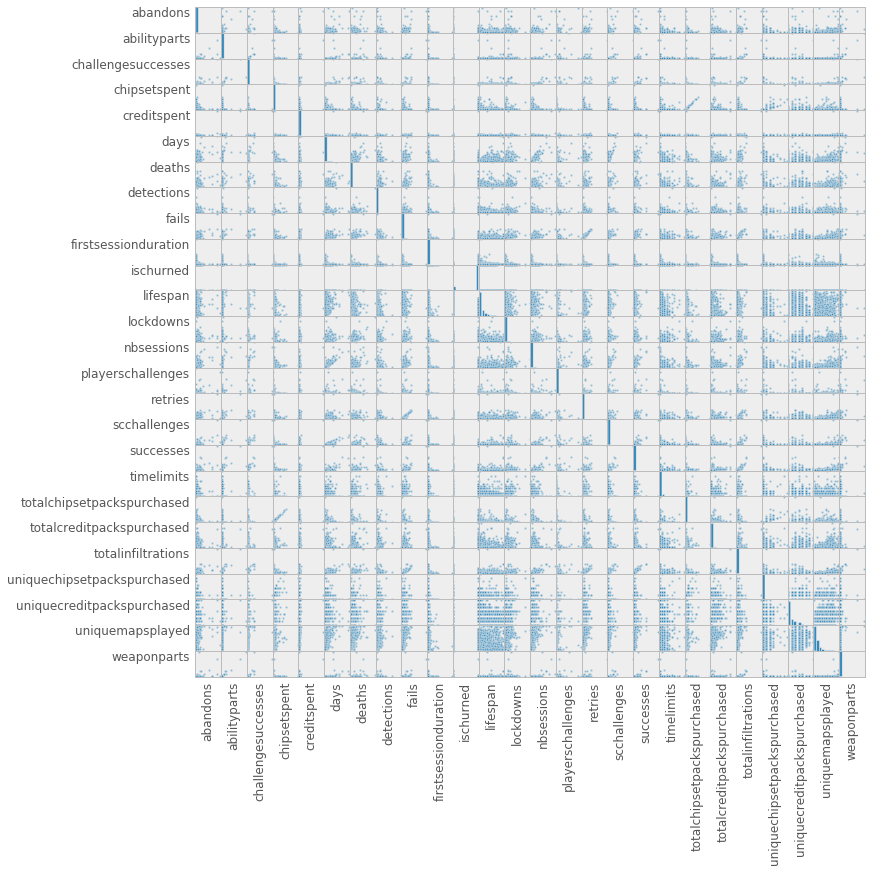

In [42]:
# Matrix of covariance

sampled_data = Churn_train[cols].sample(frac=0.1) 

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12)); # (18,18)?

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Alternative 1: Export to CSV and use R to determine which fields to drop (glm method)

In [219]:
# If on my computer: 
# pd.DataFrame.to_csv()
# import os
# path = 'C:\Users\mdeleseleuc\Documents'
# output_filename = 'Churn_train.csv'
# Churn_train.to_csv(os.path.join(path,output_filename))

# In the cluster:

Churn_train_Spark = sqlContext.createDataFrame(Churn_train) # Convert Panda df to Spark df

Churn_train_Spark.registerTempTable("mytempTableTrain") # Create temporary table 

# sqlContext.sql("drop table mytable")
sqlContext.sql("create table if not exists mytableTrain as select * from mytempTable") # create table in hive

DataFrame[]

### Alternative 2: Drop useless fields by hand (don't do that...)

In [ ]:
# Let's get rid of highly correlated variables

Churn_train = Churn_train.drop('lifespan').drop('daysincelastseen') \
             .drop('uniquemapcompleted').drop()

Churn_train.describe().transpose()

### Alternative 3: Feature Selection using tree Classifier

In [52]:
# Source 1: http://scikit-learn.org/stable/modules/feature_selection.html
"""Source 2: https://kaggle2.blob.core.windows.net/forum-message-attachments/44681/1286/
kaggle_forest.py?sv=2012-02-12&se=2016-11-14T22%3A52%3A58Z&sr=b&sp=r&sig=vizTB90DrEljcgvjIGgVVkPowHxAs%2BKO%2BZmqCzf8lms%3D"""

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble

feature_cols = [col for col in Churn_train.columns if col not in ['s__uid', 'ischurned']]

X_train = Churn_train[feature_cols]
y = Churn_train['ischurned']

X_train.shape              

(44901, 29)

In [60]:
# Get rid of NaN values
from sklearn.preprocessing import Imputer 
X_train = Imputer().fit_transform(X_train)

clf = ensemble.RandomForestClassifier()
clf.fit(X_train, y)

# Print the features importance
clf.feature_importances_  

array([ 0.43351776,  0.04264213,  0.00872871,  0.01323066,  0.00788935,
        0.02667869,  0.01354551,  0.01436285,  0.00357317,  0.00422756,
        0.00191759,  0.00503151,  0.00282198,  0.00723792,  0.00738887,
        0.37429109,  0.00359469,  0.00426691,  0.00175627,  0.00426762,
        0.00274032,  0.00472647,  0.00057156,  0.00096561,  0.00095389,
        0.00145347,  0.00761782])

In [61]:
# Take a look at the new shape

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(44901, 3)

In [59]:
# Build a forest and compute the feature importances

# Source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
          #sphx-glr-auto-examples-ensemble-plot-forest-importances-py

import numpy as np

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Three informative features = Retries, abandons and abilityparts (86% of the variance)

Feature ranking:
1. feature 15 (0.373858)
2. feature 0 (0.291313)
3. feature 1 (0.201027)
4. feature 5 (0.022639)
5. feature 2 (0.010467)
6. feature 6 (0.010450)
7. feature 3 (0.010180)
8. feature 7 (0.009962)
9. feature 13 (0.009545)
10. feature 4 (0.007979)
11. feature 14 (0.007879)
12. feature 26 (0.006703)
13. feature 21 (0.004409)
14. feature 8 (0.004124)
15. feature 16 (0.003927)
16. feature 19 (0.003878)
17. feature 11 (0.003800)
18. feature 9 (0.003777)
19. feature 17 (0.002339)
20. feature 12 (0.002259)
21. feature 20 (0.002250)
22. feature 10 (0.002095)
23. feature 25 (0.001485)
24. feature 18 (0.001251)
25. feature 23 (0.001201)
26. feature 24 (0.000641)
27. feature 22 (0.000561)


### Reprocessing: Normalize the features

Source

http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

## Using the Spark MLlib Package